In [2]:
from __future__ import absolute_import, division, print_function # Python2 compatibility
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from The_Payne import utils
from The_Payne import spectral_model
from The_Payne import fitting

# the following will be used throughout all routines
# these are the default for fitting APOGEE spectra 
# substitutes them if you train different neural networks for other purposes
# the instruction for training a new Payne is included at the end of this tutorial

# read in the default wavelength array, 
#         the apogee mask/filter used for fitting spectra : True = excluded
wavelength = utils.load_wavelength_array()
mask = utils.load_apogee_mask()
#mask = np.zeros(wavelength.size) # no masking

# read in the default neural net
#NN_coeffs = utils.read_in_neural_network()
#w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max = NN_coeffs

# if you trained your own neural net (see last part of this tutorial),
# you can load in your own neural net
tmp = np.load("/Users/storm/PycharmProjects/payne/test_network/NN_results_RrelsigN20.npz")
w_array_0 = tmp["w_array_0"]
w_array_1 = tmp["w_array_1"]
w_array_2 = tmp["w_array_2"]
b_array_0 = tmp["b_array_0"]
b_array_1 = tmp["b_array_1"]
b_array_2 = tmp["b_array_2"]
x_min = tmp["x_min"]
x_max = tmp["x_max"]
tmp.close()
NN_coeffs = (w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max)

tmp = np.load("/Users/storm/PycharmProjects/payne/test_network/NN_results_RrelsigN20_sapp.npz")
w_array_0 = tmp["w_array_0"]
w_array_1 = tmp["w_array_1"]
w_array_2 = tmp["w_array_2"]
b_array_0 = tmp["b_array_0"]
b_array_1 = tmp["b_array_1"]
b_array_2 = tmp["b_array_2"]
x_min = tmp["x_min"]
x_max = tmp["x_max"]
tmp.close()
NN_coeffs_sapp = (w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max)


In [19]:
# 5330.00008712, 5330.02508929, 5330.05009147, ..., 5614.94990853,
#       5614.97491071, 5614.99991288
lmin, lmax = 5330, 5615

In [88]:
sun_wavelength, sun_flux = np.loadtxt("/Users/storm/PhD_2022-2025/Spectra/Sun/solar_UVES.txt", usecols=(0, 1), unpack=True, dtype=float)

In [89]:
l_cut = (sun_wavelength > lmin) & (sun_wavelength < lmax)
sun_wavelength = sun_wavelength[l_cut]
sun_flux = sun_flux[l_cut]

In [90]:
print(x_min, x_max)

[ 4.          1.         -3.          0.5         4.00245339 -0.2
 -0.2        -0.8       ] [ 6.999       4.9         0.8         3.         15.99944588  0.8
  0.8         0.2       ]


In [118]:
# teff, logg, feh, vmic, vmac, mg, ti, mn
real_labels = [5.77, 4.44, 0.0, 1.0, 4., 0., 0., 0]
scaled_labels = (real_labels-x_min)/(x_max-x_min) - 0.5

In [119]:
real_spec = spectral_model.get_spectrum_from_neural_net(scaled_labels = scaled_labels, NN_coeffs = NN_coeffs, kovalev=True)
real_spec_sapp = spectral_model.get_spectrum_from_neural_net(scaled_labels = scaled_labels, NN_coeffs = NN_coeffs_sapp, kovalev=True)

In [120]:
length_spec = len(real_spec)
wave = np.linspace(lmin, lmax, length_spec)

In [122]:
wave[1] - wave[0]

np.float64(0.05000877346901689)

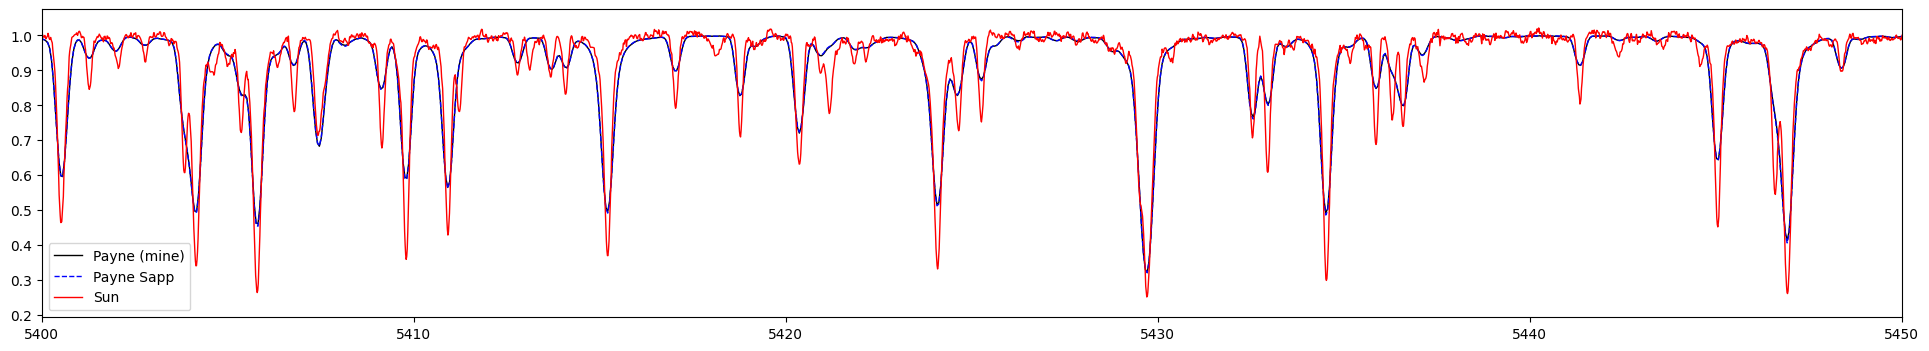

In [121]:
plt.figure(figsize=(24, 4))
plt.plot(wave, real_spec, 'k', lw=1, label = 'Payne (mine)')
plt.plot(wave, real_spec_sapp, 'blue', lw=1, label = 'Payne Sapp', linestyle='--')
plt.plot(sun_wavelength, sun_flux, lw=1, color='red', label = 'Sun')
plt.xlim(5400, 5450)
plt.legend()
plt.show()

(5400.0, 5401.0)

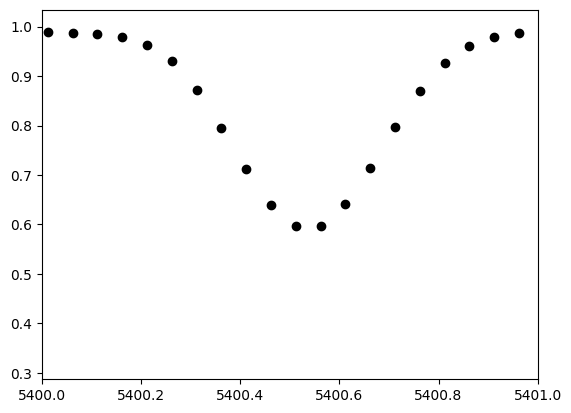

In [127]:
plt.scatter(wave, real_spec, color='k', label = 'Payne (mine)')
plt.xlim(5400, 5401)

In [101]:
spec_err = 1e-2*np.ones(len(wavelength))

# for a single-star model, the format of "labels" is [Teff, Logg, Vturb [km/s],
#              [C/H], [N/H], [O/H], [Na/H], [Mg/H],\
#              [Al/H], [Si/H], [P/H], [S/H], [K/H],\
#              [Ca/H], [Ti/H], [V/H], [Cr/H], [Mn/H],\
#              [Fe/H], [Co/H], [Ni/H], [Cu/H], [Ge/H],\
#              C12/C13, Vmacro [km/s], radial velocity (RV)
real_labels = scaled_labels = [5770, 4.44, 1.0,\
                               0., 0., 0., 0., 0.,\
                               0., 0., 0., 0., 0.,\
                               0., 0., 0., 0., 0.,\
                               0., 0., 0., 0., 0.,\
                               90., 6., 3.] # assuming RV = 3 km/s. 

# scale the labels (except for RV) the same as it was done during the training of the network
scaled_labels[:-1] = (real_labels[:-1]-x_min)/(x_max-x_min) - 0.5
print(np.array(scaled_labels).shape)

real_spec = spectral_model.get_spectrum_from_neural_net(scaled_labels = scaled_labels[:-1], NN_coeffs = NN_coeffs)
real_spec = utils.doppler_shift(wavelength, real_spec, scaled_labels[-1])

# zoom in on a small region of the spectrum so we can see what's going on.
lambda_min, lambda_max = 16000, 16100# for plotting 
m = (wavelength < lambda_max) & (wavelength > lambda_min)
plt.figure(figsize=(14, 4))
plt.plot(wavelength[m], real_spec[m], 'k', lw=0.5)
plt.xlim(lambda_min, lambda_max)
plt.ylim(0.7, 1.05)

ValueError: operands could not be broadcast together with shapes (25,) (8,) 

Now let's add some noise to this model spectrum, and then fit it to see if we can recover the labels we put in. 

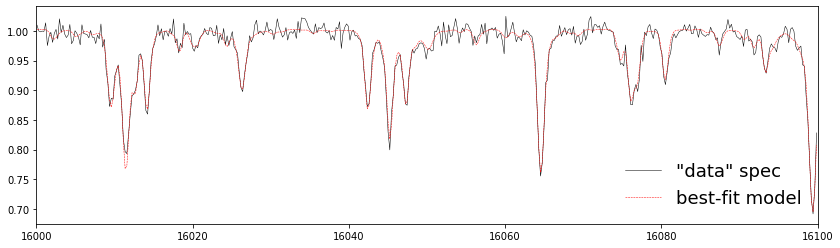

In [4]:
data_spec = real_spec + 0.01*np.random.randn(len(real_spec))

popt, pstd, model_spec = fitting.fit_normalized_spectrum_single_star_model(\
                                norm_spec = data_spec, spec_err = spec_err,\
                                NN_coeffs = NN_coeffs, wavelength = wavelength, mask=mask, p0 = None)

plt.figure(figsize=(14, 4))
m = (wavelength < lambda_max) & (wavelength > lambda_min)
plt.plot(wavelength[m], data_spec[m], 'k', lw=0.5, label = '"data" spec')
plt.plot(wavelength[m], model_spec[m], 'r--', lw=0.5, label = 'best-fit model')
plt.xlim(lambda_min, lambda_max)
plt.legend(loc = 'best', frameon = False, fontsize = 18)

In [5]:
# verify that our best-fit labels are close to what we put in. 
print(popt)

[ 5.80423982e+03  4.47429523e+00  1.02808134e+00  9.12571816e-03
  2.64261923e-02  7.91369557e-02 -9.80682826e-02  1.06031651e-02
  2.64754435e-02  8.97618519e-03 -3.19894979e-01 -2.30204863e-02
 -1.55436534e-02 -7.84262672e-04 -7.72626725e-02 -3.18917216e-03
 -2.51876435e-02 -1.77773554e-02  1.93352287e-02  1.07392503e-02
  8.41148372e-03  1.94582350e-01 -6.91791527e-02  3.22752775e+01
  5.10397306e+00  2.98582662e+00]


Now that we've seen how to generate and fit model spectra, let's download an actual APOGEE spectrum. Here we'll download a "combined" spectrum. 

Note: Here we adopt APOGEE DR14. Edit os.environs in the "process_spectra" source codes for a later version of the APOGEE data release. Since our neural net training set was normalized using the DR12 wavelength format, even though the spectrum is from DR14, we will resample it into the DR12 wavelength grid.

(16000, 16100)

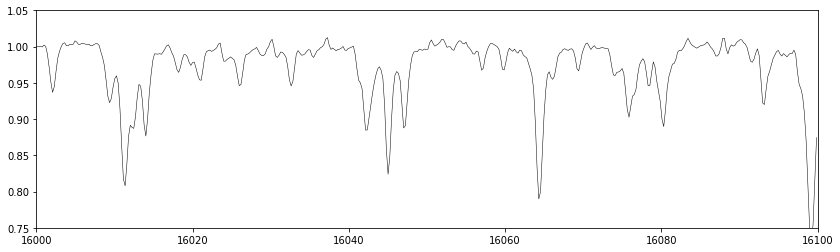

In [6]:
from The_Payne import process_spectra

apogee_id = '2M18513961+4338099' # make sure the apogee id is in the right string format
spec, spec_err = process_spectra.get_combined_spectrum_single_object(apogee_id = apogee_id, 
                    catalog = None, save_local = False)

plt.figure(figsize=(14, 4))
m = (spec_err < 0.1) & (wavelength < lambda_max) & (wavelength > lambda_min)
plt.plot(wavelength[m], spec[m], 'k', lw=0.5)
plt.ylim(0.75, 1.05)
plt.xlim(lambda_min, lambda_max)

Now let's fit this spectrum with The-Payne-interpolated model.

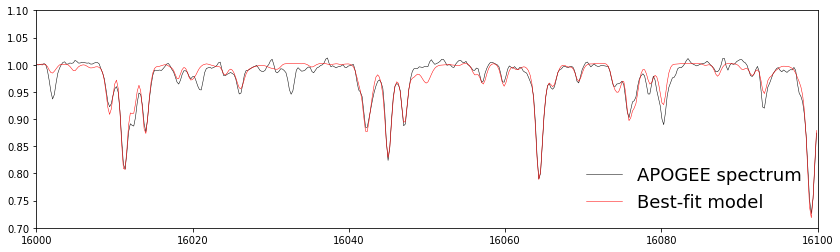

In [7]:
popt, pstd, best_fit_spec = fitting.fit_normalized_spectrum_single_star_model(norm_spec = spec, 
        spec_err = spec_err, NN_coeffs = NN_coeffs, wavelength=wavelength, mask=mask, p0 = None)

plt.figure(figsize=(14, 4))
plt.plot(wavelength[m], spec[m], 'k', lw=0.5, label = 'APOGEE spectrum')
plt.plot(wavelength[m], best_fit_spec[m], 'r', lw=0.5, label = 'Best-fit model')
plt.xlim(lambda_min, lambda_max)
plt.ylim(0.7, 1.1)
plt.legend(loc = 'best', frameon = False, fontsize= 18)

If you have a different training grid, you can also train your own neural networks. But do remember to adopt, during spectral fitting, a different set of continuum pixels and/or spectroscopic mask tailored for your need. 

Note that, this part of the codes requires GPU (CUDA). It will not run if you don't have CUDA installed.

In [ ]:
import numpy as np
from The_Payne import training
from The_Payne import utils

# load the default training set. Note that, due to the GitHub size limit,
# this training set is a small subset of what I used to train the default network 
training_labels, training_spectra, validation_labels, validation_spectra = utils.load_training_data()
# label array unit = [n_spectra, n_labels]
# spectra_array unit = [n_spectra, n_pixels]

# The validation set is used to independently evaluate how well the neural net
# is emulating the spectra. If the network overfits the spectral variation, while 
# the loss will continue to improve for the training set, the validation set
# should exhibit a worsen loss.

# the codes outputs a numpy array ""NN_normalized_spectra.npz" 
# which stores the trained network parameters
# and can be used to substitute the default one in the directory neural_nets/
# it will also output a numpy array "training_loss.npz"
# which stores the progression of the training and validation losses

training.neural_net(training_labels, training_spectra,\
                    validation_labels, validation_spectra,\
                    num_neurons=300, learning_rate=1e-4,\
                    num_steps=1e4, batch_size=128)

# a larger batch_size (e.g. 512) when possible is desirable
# here we choose batch_size=128 above because the sample training set is limited in size


Plot the loss function of the training set and the validation set. The loss function has plateaued after 1e4 steps. We were being conservative and trained 10 times longer. Depending on the scale of your problem, you might want to change the parameter "num_steps" above.

Text(0, 0.5, 'Loss')

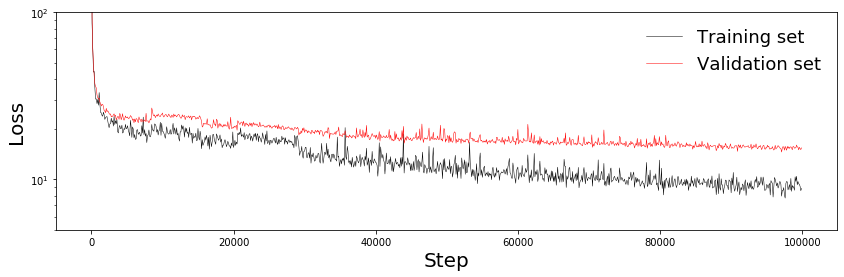

In [8]:
tmp = np.load("training_loss.npz") # the output array also stores the training and validation loss
training_loss = tmp["training_loss"]
validation_loss = tmp["validation_loss"]

plt.figure(figsize=(14, 4))
plt.plot(np.arange(training_loss.size)*100, training_loss, 'k', lw=0.5, label = 'Training set')
plt.plot(np.arange(training_loss.size)*100, validation_loss, 'r', lw=0.5, label = 'Validation set')
plt.legend(loc = 'best', frameon = False, fontsize= 18)
plt.yscale('log')
plt.ylim([5,100])
plt.xlabel("Step", size=20)
plt.ylabel("Loss", size=20)

**Practical notes:**

Fitting spectra with The Payne is pretty fast. Fitting a spectrum typically takes about 0.1 CPU seconds.

Training neural networks should not be too slow, either. Training the default multilayer perceptron network with 10,0000 training spectra should take at most take a few hours (with a V100 GPU). We also included the option to train a large ResNet that could provide better interpolation if needed. Training a ResNet should take about a GPU day.